In [146]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [147]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)
# x = dataset.iloc[ : , 2:].values

二.数据分析

1.总体预览

In [148]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* PassengerID（ID）
* Survived(存活与否)
* Pclass（客舱等级，较为重要）
* Name（姓名，可提取出更多信息）
* Sex（性别，较为重要）
* Age（年龄，较为重要）
* Parch（直系亲友）
* SibSp（旁系）
* Ticket（票编号）
* Fare（票价）
* Cabin（客舱编号）
* Embarked（上船的港口编号）

In [149]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [150]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

1)Sex Feature：女性幸存率远高于男性

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

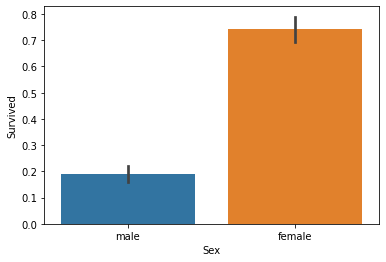

In [151]:
sns.barplot(x="Sex", y="Survived", data=train)

2)Pclass Feature：乘客社会等级越高，幸存率越高

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

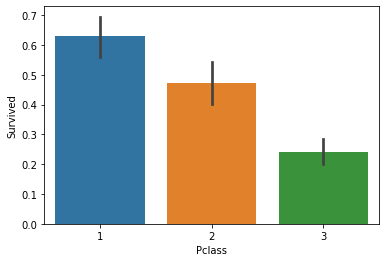

In [152]:
sns.barplot(x="Pclass", y="Survived", data=train)

3)SibSp Feature：配偶及兄弟姐妹数适中的乘客幸存率更高

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

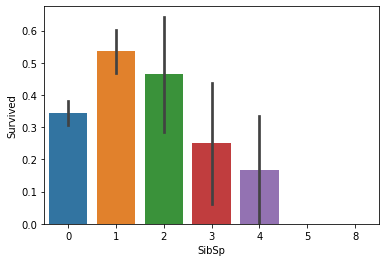

In [153]:
sns.barplot(x="SibSp", y="Survived", data=train)

4)Parch Feature：父母与子女数适中的乘客幸存率更高

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

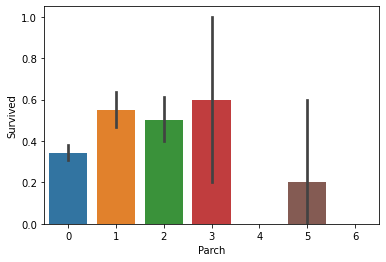

In [154]:
sns.barplot(x="Parch", y="Survived", data=train)

5)从不同生还情况的密度图可以看出，在年龄15岁的左侧，生还率有明显差别，密度图非交叉区域面积非常大，但在其他年龄段，则差别不是很明显，认为是随机所致，因此可以考虑将此年龄偏小的区域分离出来。

Text(12.389771412037035, 0.5, 'density')

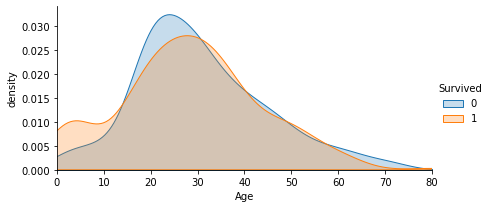

In [155]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age') 
plt.ylabel('density') 

6)Embarked登港港口与生存情况的分析 结果分析:C地的生存率更高,这个也应该保留为模型特征.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

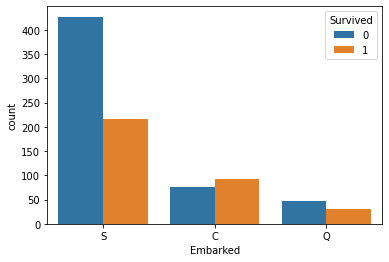

In [156]:
sns.countplot(x='Embarked', hue='Survived',data=train)

7)Title Feature(New)：不同称呼的乘客幸存率不同

新增Title特征，从姓名中提取乘客的称呼，归纳为六类

<AxesSubplot:xlabel='Title', ylabel='Survived'>

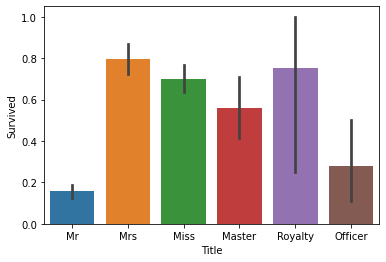

In [157]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data)

8)FamilyLabel Feature(New)：家庭人数为2到4的乘客幸存率较高

新增FamilyLabel特征，先计算FamilySize=Parch+SibSp+1，然后把FamilySize分为三类

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

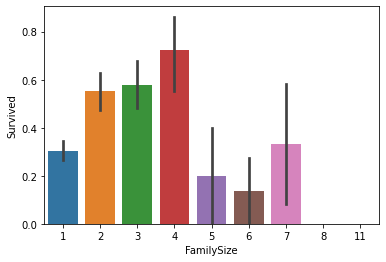

In [158]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data)

按生存率把FamilySize分为三类，构成FamilyLabel特征。

<AxesSubplot:xlabel='FamilyLabel', ylabel='Survived'>

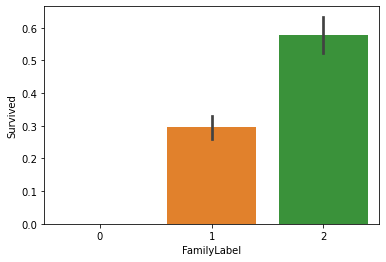

In [159]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data)

9)Deck Feature(New)：不同甲板的乘客幸存率不同

新增Deck特征，先把Cabin空缺值填充为'Unknown'，再提取Cabin中的首字母构成乘客的甲板号。

<AxesSubplot:xlabel='Deck', ylabel='Survived'>

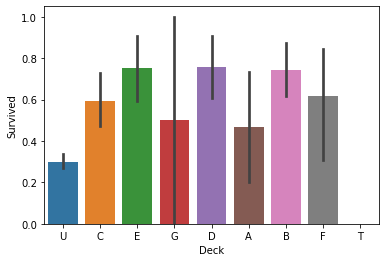

In [114]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data)

10)TicketGroup Feature(New)：与2至4人共票号的乘客幸存率较高

新增TicketGroup特征，统计每个乘客的共票号数。

<AxesSubplot:xlabel='TicketGroup', ylabel='Survived'>

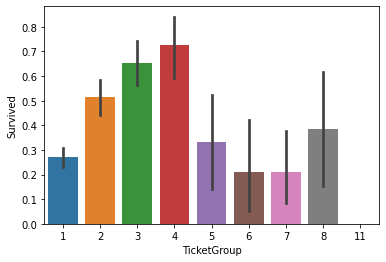

In [115]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

按生存率把TicketGroup分为三类。

<AxesSubplot:xlabel='TicketGroup', ylabel='Survived'>

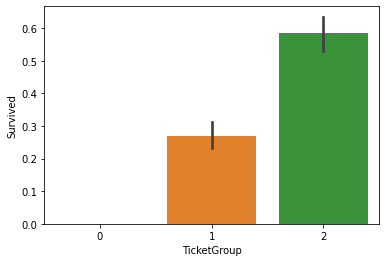

In [116]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

3.数据清洗

1)缺失值填充

Age Feature：Age缺失量为263，缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值。

In [117]:
from sklearn.ensemble import RandomForestRegressor
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notna()].values
unknown_age = age_df[age_df.Age.isna()].values
X = known_age[:, 1:]
y = known_age[:, 0]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isna()), 'Age' ] = predictedAges 

Embarked Feature：Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C。

In [118]:
all_data[all_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,1,1,B,2
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,1,1,B,2


In [119]:
all_data.groupby(by=["Pclass","Embarked"]).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [120]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

Fare Feature：Fare缺失量为1，缺失Fare信息的乘客的Embarked为S，Pclass为3，所以用Embarked为S，Pclass为3的乘客的Fare中位数填充。

In [121]:
all_data[all_data['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,Unknown,S,Mr,1,1,U,1


In [122]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

2)同组识别

同组识别
把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。

In [123]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难。

In [124]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5, 0, 'AverageSurvived')

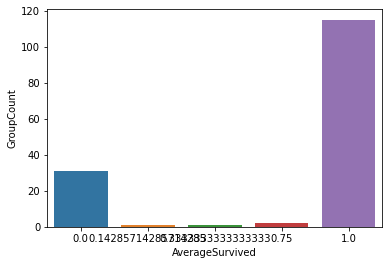

In [125]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"]).set_xlabel('AverageSurvived')

绝大部分成年男性组的平均存活率也为1或0。

In [126]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。

In [137]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

KeyError: 'Column not found: Survived'

为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。

In [145]:
train=all_data.loc[all_data['Survived'].notna()]
test=all_data.loc[all_data['Survived'].isna()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

KeyError: 'Surname'

3)特征转换

选取特征，转换为数值变量，划分训练集和测试集。

In [142]:
all_data=pd.concat([train, test])
print(all_data.head(5))
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notna()]
test=all_data[all_data['Survived'].isna()].drop('Survived',axis=1)
X = train.values[:,1:]
y = train.values[:,0]

   Survived  Pclass   Age     Fare  FamilyLabel  TicketGroup  Sex_female  \
0       0.0       3  22.0   7.2500            2            1           0   
1       1.0       1  38.0  71.2833            2            2           1   
2       1.0       3  26.0   7.9250            1            1           1   
3       1.0       1  35.0  53.1000            2            2           1   
4       0.0       3  35.0   8.0500            1            1           0   

   Sex_male  Embarked_C  Embarked_Q  ...  Title_Royalty  Deck_A  Deck_B  \
0         1           0           0  ...              0       0       0   
1         0           1           0  ...              0       0       0   
2         0           0           0  ...              0       0       0   
3         0           0           0  ...              0       0       0   
4         1           0           0  ...              0       0       0   

   Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  Deck_U  
0       0       0       0       

KeyError: "['Title', 'Embarked', 'Sex', 'Deck'] not in index"